In [1]:
import pandas as pd
import numpy as np
import plot_params
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz
import scipy.stats as stats

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.inspection import PartialDependenceDisplay
from sklearn.tree import export_graphviz
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from imblearn.combine import SMOTEENN
from joblib import dump

plot_params.apply_rcparams()

starting without killing duplicates to see if it makes a diff


In [2]:
df = pd.read_csv("creditcard.csv")
df = df.rename(columns={'Class' : 'Fraud'})

In [3]:
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
df.duplicated().sum()

1081

In [5]:
df[df.duplicated(keep=False)]['Fraud'].value_counts()

0    1822
1      32
Name: Fraud, dtype: int64

In [6]:
print(df.describe())

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271e+00  1.23709

In [7]:
print(df.nunique())

Time      124592
V1        275663
V2        275663
V3        275663
V4        275663
V5        275663
V6        275663
V7        275663
V8        275663
V9        275663
V10       275663
V11       275663
V12       275663
V13       275663
V14       275663
V15       275663
V16       275663
V17       275663
V18       275663
V19       275663
V20       275663
V21       275663
V22       275663
V23       275663
V24       275663
V25       275663
V26       275663
V27       275663
V28       275663
Amount     32767
Fraud          2
dtype: int64


In [8]:
corr_mat = df.corr()
X = df.drop('Fraud', axis=1)
y = df['Fraud']
mi_scores = mutual_info_classif(X, y)
mi_df = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

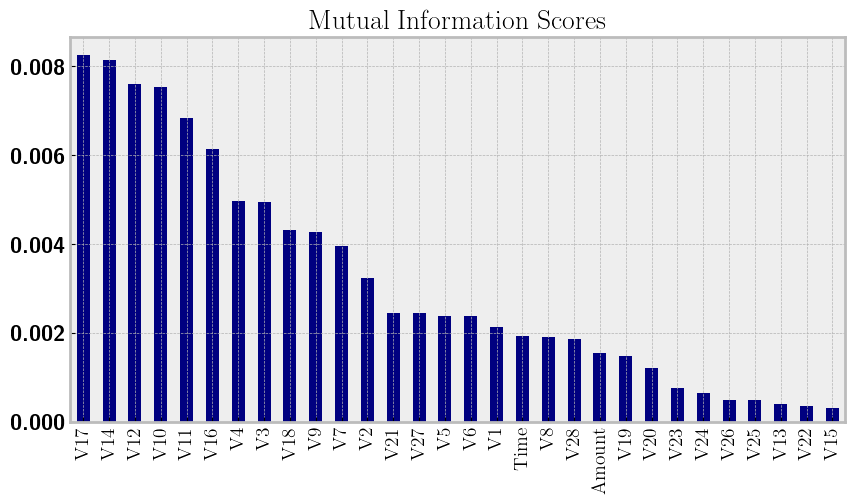

In [9]:
mi_df.plot(kind='bar', figsize=(10, 5), title='Mutual Information Scores', color='navy')
plt.savefig('images/mutual_info_before.jpg')

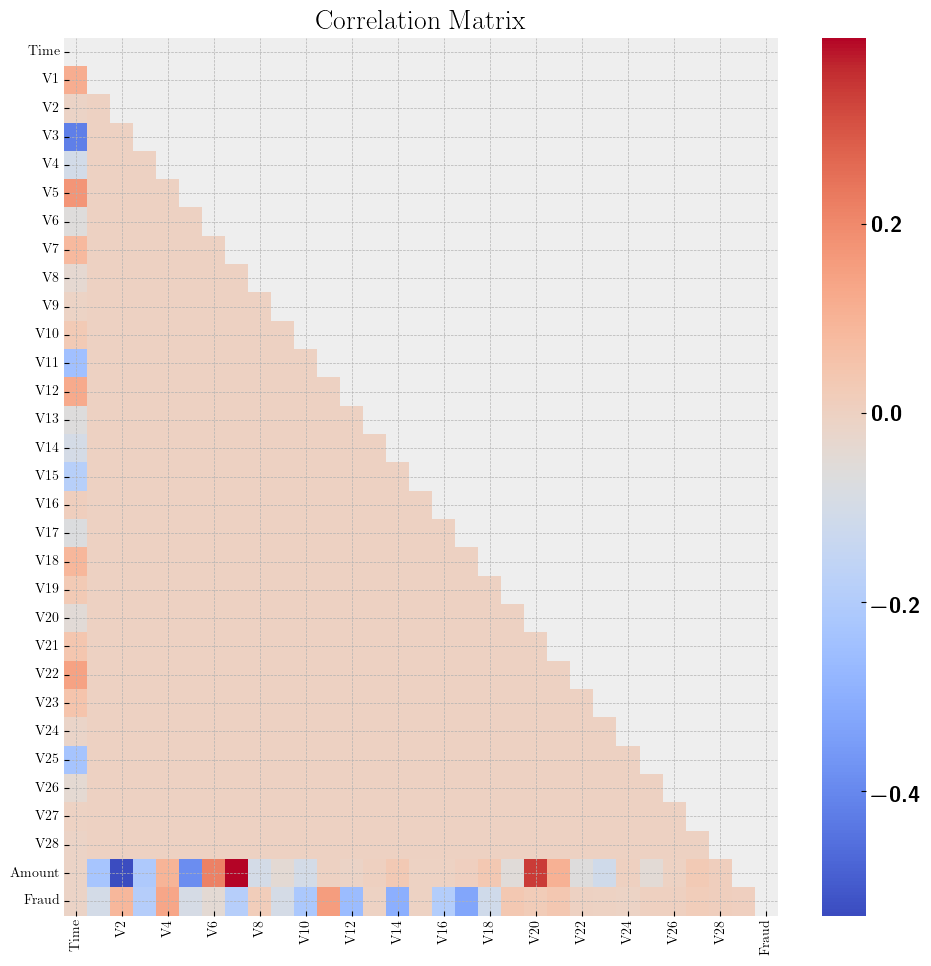

In [ ]:
mask = np.triu(np.ones_like(corr_mat, dtype=bool))
plt.figure(figsize=(10, 10))
ax = sns.heatmap(corr_mat, 
                 annot=False, cmap="coolwarm", 
                 fmt=".2f", mask=mask, annot_kws={'size':10})
plt.title("Correlation Matrix")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig("images/corr_before.jpg")

<Axes: >

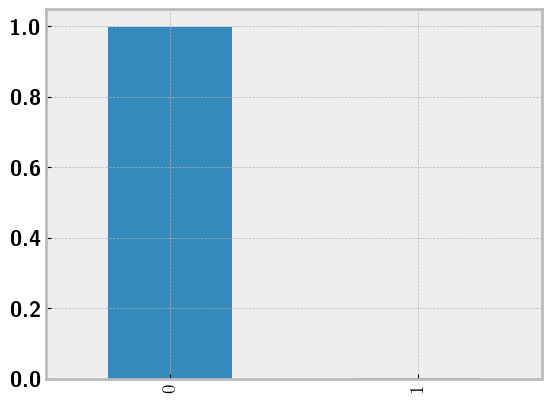

In [11]:
df['Fraud'].value_counts(normalize=True).plot(kind='bar')

From looking at MI and the correlation matrix I am going to drop columns V13, V15, V22, V23, V24, V25, V26. And there was a large correlation with V17 and V18 after all the resampling and scaling so I drop both.

In [12]:
#df_drop = df.drop(columns=['V13', 'V15', 'V17', 'V18', 'V22', 'V23', 'V24', 'V25','V26'])
df_drop = df

In [13]:
X = df_drop.drop('Fraud', axis=1)
y = df_drop['Fraud']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, \
        y, test_size=0.2, random_state=12, stratify=y)
smote_enn = SMOTEENN(random_state=12)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)


In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_
print("Explained variance per component:", explained_variance)
print("Cumulative explained variance:", explained_variance.cumsum())

X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)


Explained variance per component: [0.38926958 0.09283166 0.06816058 0.05398426 0.05269556 0.04111828
 0.03761759 0.03571673 0.03002936 0.02839327 0.02620191 0.02253526
 0.02035813 0.01937751 0.01487813 0.01299729 0.0102042 ]
Cumulative explained variance: [0.38926958 0.48210123 0.55026181 0.60424607 0.65694163 0.69805992
 0.7356775  0.77139423 0.8014236  0.82981687 0.85601878 0.87855404
 0.89891217 0.91828968 0.93316781 0.9461651  0.9563693 ]


In [16]:
mi_scores = mutual_info_classif(X_resampled, y_resampled)
mi_df = pd.Series(mi_scores, index=X_resampled.columns).sort_values(\
    ascending=False)

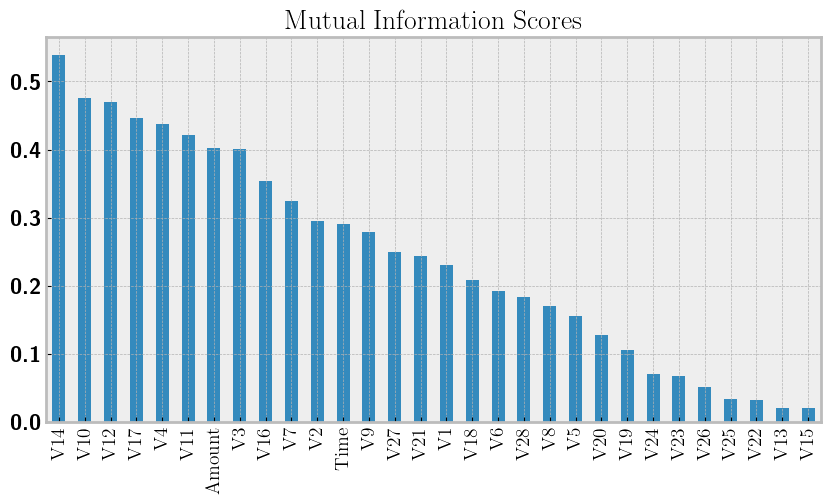

In [17]:
mi_df.plot(kind='bar', figsize=(10, 5), title='Mutual Information Scores')
plt.show()

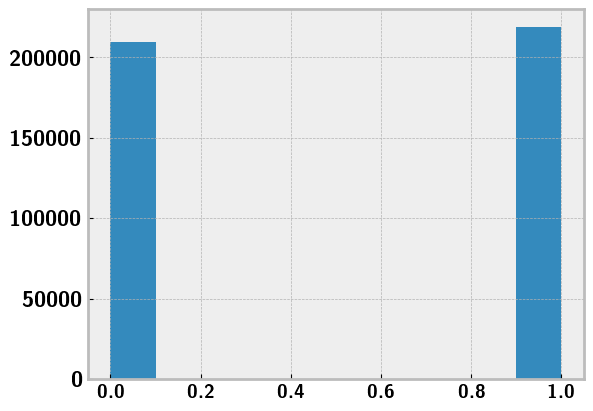

In [18]:
plt.hist(y_resampled)
plt.show()

In [19]:
dump(X_pca, 'X_train.joblib')
dump(y_resampled, 'y_train.joblib')
X_test_pca = pca.transform(X_test_scaled)
dump(X_test_pca, 'X_test.joblib')
dump(y_test, 'y_test.joblib')

['y_test.joblib']